In [1]:
%load_ext autoreload

%autoreload 2
    
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import torch
from torchvision import transforms
from torchvision.datasets import MNIST
from torchir.utils import IRDataSet
from tqdm import tqdm
from pathlib import Path

DEST_DIR = Path('./MNIST_output')

Then we create a specific dataset class that selects MNIST instances with a specific class label. Here we take all number 9s.

In [2]:
class MNISTSubSet(MNIST):
    '''
    A Dataset class that selects a single type of MNIST digit.
    '''
    def __init__(self, label, rng=np.random.default_rng(), *args, **kwargs):
        super().__init__(*args, **kwargs)
        assert(label >= 0 and label <= 9)
        idcs = torch.where(self.targets == label)
        
        self.data = self.data[idcs]
        self.targets = self.targets[idcs]

        self.transform = transform
        self.rng = rng
        
    def __getitem__(self, idx):
        return super().__getitem__(idx)[0] # only return image


Next we set up the dataloaders.

In [3]:
# Create a new instance of the dataset
rng = np.random.default_rng(808)

# transforms.ToTensor(): Converts a PIL (Python Imaging Library) image or a numpy array to a PyTorch tensor. Additionally, it scales the 
# image's pixel intensity values to the range [0, 1].
# transforms.Normalize(): Normalizes a tensor image with mean and standard deviation. Here, it takes the values of the tensor 
# (originally in [0,1] due to ToTensor()) and transforms them to the range [-1,1]
transform=transforms.Compose([transforms.ToTensor(),
                              transforms.Normalize((0.5), (0.5)),
                             ])
ds_train_subset = MNISTSubSet(label=9, rng=rng, root='./MNIST_datasets/',  transform=transform, download=True, train=True)

We reserve part of the training set for validation. Note that we only select a small number for validation. This will become clear immediately after this block.

In [4]:
val_set_size = 20
train_set_size = len(ds_train_subset) - val_set_size
ds_train_subset, ds_validation_subset = torch.utils.data.random_split(ds_train_subset, [train_set_size, val_set_size], 
                                                        generator=torch.Generator().manual_seed(808))
ds_test_subset = MNISTSubSet(label=9, rng=rng, root='./MNIST_datasets/',  transform=transform, download=True, train=False)
print(f'Training subset size: {len(ds_train_subset)}')
print(f'Validation subset size: {len(ds_validation_subset)}')
print(f'Test subset size: {len(ds_test_subset)}')

Training subset size: 5929
Validation subset size: 20
Test subset size: 1009


Now we will employ a convenience class to convert the training and validation data sets into image registration sets. The new class will provide all possible permutations of the input dataset. Note that this will heavily increase the number of training instances (i.e. there are many fixed and moving image permutations). Note that we will use the test set later in a different manner.

In [6]:
# Each entry in the dataset will be a dictionary containing a 'fixed' and a 'moving' image.
ds_train = IRDataSet(ds_train_subset)
ds_validation = IRDataSet(ds_validation_subset)

# IRDataSet will create pairs of x and all other items in ds to serve as fixed and moving images for registration tasks. 
# That's why the length of this dataset is len(ds) × len(ds).
print(f'Training IR set size: {len(ds_train)}')
print(f'Validation IR set size: {len(ds_validation)}')

Training IR set size: 592900
Validation IR set size: 400


Note that each instance of an IR dataset is a permutation of a fixed and moving image. This results in a very high number of possible permutations. Since Pytorch Lightning does not play well with iterations and rather likes epochs, we limit the number of permutations per epoch by setting up our own data samplers:

In [6]:
batch_size = 32
training_batches = 100
validation_batches = 10

# RandomSampler: Samples elements randomly from a given list of indices, with replacement.
# num_samples: ensures that we get the desired number of training samples for each epoch.
train_sampler = torch.utils.data.RandomSampler(ds_train, replacement=True, 
                                               num_samples=training_batches*batch_size, 
                                               generator=torch.Generator().manual_seed(808))

# DataLoader: Combines a dataset and a sampler, and provides an iterable over the given dataset.
train_loader = torch.utils.data.DataLoader(ds_train, batch_size, sampler=train_sampler)

# Since no sampler is provided, it will simply iterate over the dataset in its original order.
val_loader = torch.utils.data.DataLoader(ds_validation, batch_size)

In [7]:
def visualize(model):
    avg_moving = np.zeros((28, 28), dtype=float)
    avg_warped = np.zeros((28, 28), dtype=float)
    model = model.cuda()
    model.eval()
    fixed = ds_test_subset[0]
    with torch.no_grad():
        for moving in tqdm(ds_test_subset):
            warped = model(fixed[None].cuda(), moving[None].cuda()).detach().squeeze().cpu().numpy()
            avg_moving += moving.squeeze().cpu().numpy() / len(ds_test_subset)
            avg_warped += warped / len(ds_test_subset)

    fig, axarr = plt.subplots(1, 3, figsize=(10, 3.5))
    axarr[0].imshow(-fixed.squeeze().cpu().numpy(), cmap='gray', vmin=-1, vmax=1)
    axarr[1].imshow(-avg_moving, cmap='gray', vmin=-1, vmax=1)
    axarr[2].imshow(-avg_warped, cmap='gray', vmin=-1, vmax=1)
    for ax in axarr.ravel():
        ax.axis('off')

    axarr[0].set_title('fixed image')
    axarr[1].set_title('images before registration')
    axarr[2].set_title('images after registration')

    fig.suptitle('Deformable image registration network (DIRNet)')

We have setup all our data classes and now we can start the image registration experiments.

If you want to inspect the data, use tensorboard. The logs are stored in the specified `DEST_DIR`.
> tensorboard --logdir=./output/lightning_logs

## 先试一下单独一个框架怎么load 参数

In [2] I also demonstrated that multiple coarse-to-fine registration layers improve image registration. Now let's implement this using the DLIRFramework module. I chose a dynamic implementation where we add a layer. We train the layer. We add another layer and fix the weight of the previous layer. We train the new layer. Etc...

In [8]:
import pytorch_lightning as pl
from torchir.networks import DIRNet
from torchir.metrics import NCC
from torchir.transformers import BsplineTransformer
from torchir.dlir_framework import DLIRFramework

c:\Users\s4692034\AppData\Local\anaconda3\envs\cardiac\lib\site-packages\torchaudio\backend\utils.py:74: UserWarning: No audio backend is available.
  warnings.warn("No audio backend is available.")


In [9]:
class LitDIRNet(pl.LightningModule):
    def __init__(self):
        super().__init__()
        grid_spacing = (8, 8)
        self.dirnet = DIRNet(kernels=16, grid_spacing=grid_spacing)
        self.bspline_transformer = BsplineTransformer(ndim=2, upsampling_factors=grid_spacing)
        self.metric = NCC()
    
    def configure_optimizers(self):
        lr = 0.001

        # Configures and returns the optimizer (Adam with AMSGrad) to be used for training.
        optimizer = torch.optim.Adam(self.dirnet.parameters(), lr=lr, amsgrad=True)
        return optimizer

    def forward(self, fixed, moving):
        params = self.dirnet(fixed, moving)

        # Uses the BsplineTransformer to produce the warped image.
        warped = self.bspline_transformer(params, fixed, moving)
        return warped
    
    def training_step(self, batch, batch_idx):
        warped = self(batch['fixed'], batch['moving'])

        # Computes the warped image and calculates the loss using the NCC metric.
        loss = self.metric(batch['fixed'], warped)

        # Logs the training loss.
        self.log('NCC/training', loss)
        return loss
    
    def validation_step(self, batch, batch_idx):
        warped = self(batch['fixed'], batch['moving'])
        loss = self.metric(batch['fixed'], warped)
        self.log('NCC/validation', loss)
        return loss  

In [12]:
model1 = LitDIRNet()
trainer = pl.Trainer(default_root_dir=DEST_DIR, 
                     log_every_n_steps=50,
                     val_check_interval=50, 
                     max_epochs=100,
                     devices=1)
trainer.fit(model1, train_loader, val_loader)

trainer.save_checkpoint(DEST_DIR / 'mnist_ir_8.ckpt')
torch.save(model1.state_dict(), DEST_DIR / 'mnist_dlir_8.pt')

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA RTX A6000') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name                | Type               | Params
-----------------------------------------------------------
0 | dirnet              | DIRNet             | 10.2 K
1 | bspline_transformer | BsplineTransformer | 1.0 K 
2 | metric              | NCC                | 0     
-----------------------------------------------------------
10.2 K    Trainable params
1.0 K     Non-trainable params
11.2 K    Total params
0.045     Total estimated mod

Sanity Checking DataLoader 0:   0%|          | 0/2 [00:00<?, ?it/s]

c:\Users\s4692034\AppData\Local\anaconda3\envs\cardiac\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:442: PossibleUserWarning: The dataloader, val_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 24 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


c:\Users\s4692034\AppData\Local\anaconda3\envs\cardiac\lib\site-packages\torch\functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\TensorShape.cpp:3484.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
c:\Users\s4692034\AppData\Local\anaconda3\envs\cardiac\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:442: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 24 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Epoch 99: 100%|██████████| 100/100 [00:03<00:00, 31.22it/s, v_num=3]

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 99: 100%|██████████| 100/100 [00:03<00:00, 31.22it/s, v_num=3]


ImportError: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html













































































































100%|██████████| 1009/1009 [00:02<00:00, 355.40it/s]
Exception ignored in: <function tqdm.__del__ at 0x00000184083DD3F0>
Traceback (most recent call last):
  File "c:\Users\s4692034\AppData\Local\anaconda3\envs\cardiac\lib\site-packages\tqdm\std.py", line 1149, in __del__
    self.close()
  File "c:\Users\s4692034\AppData\Local\anaconda3\envs\cardiac\lib\site-packages\tqdm\notebook.py", line 278, in close
    self.disp(bar_style='danger', check_delay=False)
AttributeError: 'tqdm_notebook' object has no attribute 'disp'


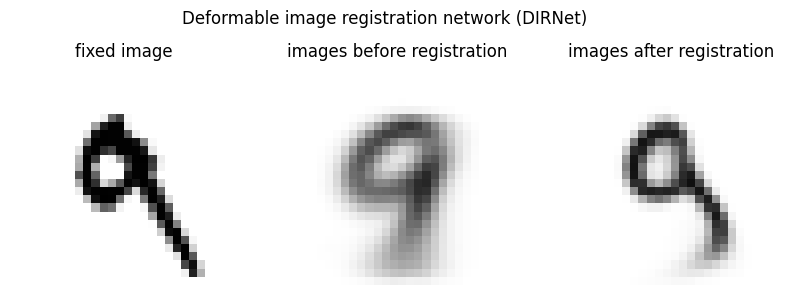

In [19]:
visualize(model1)

















































100%|██████████| 1009/1009 [00:02<00:00, 394.34it/s]


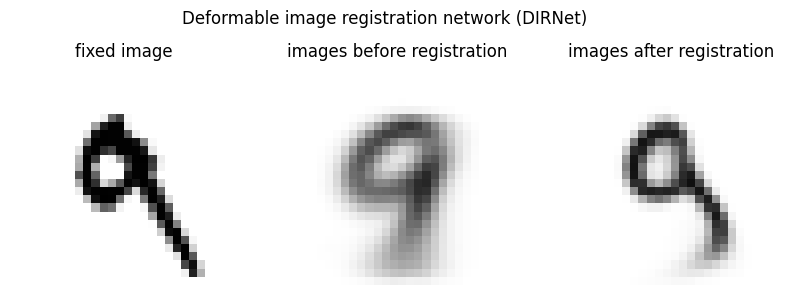

In [20]:
# 看看这俩是不是一样的
model2 = LitDIRNet.load_from_checkpoint(DEST_DIR / 'mnist_ir_8.ckpt')
visualize(model2)

# 怎么利用DVF，试试         多层怎么办

dirnet_model = DIRNet(...)
bspline_transformer = BsplineTransformer(...)

# Predict the B-spline coefficients for a specific pair
bspline_coefficients = dirnet_model(fixed_image, moving_image)

# Extract the DVF
dvf = bspline_transformer.get_dvf(bspline_coefficients, fixed_image.shape)

















































100%|██████████| 1009/1009 [00:02<00:00, 390.81it/s]


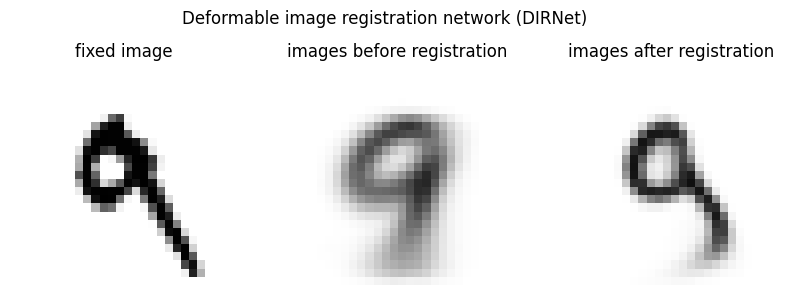

In [21]:
model3 = LitDIRNet()
model3.load_state_dict(torch.load(DEST_DIR / 'mnist_dlir_8.pt'))
visualize(model3)



















































100%|██████████| 1009/1009 [00:02<00:00, 392.01it/s]


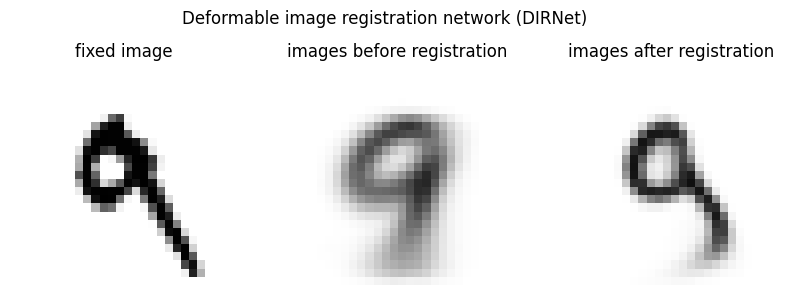

In [22]:
model4 = LitDIRNet.load_from_checkpoint("C:\\Users\\s4692034\\Documents\\GitHub\\TorchIR\\MNIST_output\\lightning_logs\\version_3\\checkpoints\\epoch=99-step=10000.ckpt")
visualize(model4)

## 接着试试两个stage组合要怎么才能load参数

In [24]:
class LitDLIRFramework(pl.LightningModule):
    def __init__(self, only_last_trainable=True):
        super().__init__()
        self.dlir_framework = DLIRFramework(only_last_trainable=only_last_trainable)
        self.add_stage = self.dlir_framework.add_stage
        self.metric = NCC()
    
    def configure_optimizers(self):
        lr = 0.001
        weight_decay = 0
        optimizer = torch.optim.Adam(self.dlir_framework.parameters(), lr=lr, weight_decay=weight_decay, amsgrad=True)
        return {'optimizer': optimizer}

    def forward(self, fixed, moving):
        warped = self.dlir_framework(fixed, moving)
        return warped
    
    def training_step(self, batch, batch_idx):
        warped = self(batch['fixed'], batch['moving'])
        loss = self.metric(batch['fixed'], warped)
        self.log('NCC/training', loss)
        return loss
    
    def validation_step(self, batch, batch_idx):
        warped = self(batch['fixed'], batch['moving'])
        loss = self.metric(batch['fixed'], warped)
        self.log('NCC/validation', loss)
        return loss
    
    @classmethod
    def custom_load_from_checkpoint(cls, checkpoint_path, *args, **kwargs):
        # Load the checkpoint data
        checkpoint_data = torch.load(checkpoint_path)
        
        # Adjust keys in the state dict
        fixed_state_dict = checkpoint_data['state_dict']
        corrected_state_dict = {f"dlir_framework.{k}": v for k, v in fixed_state_dict.items()}
        
        # Replace the state_dict in the checkpoint data with the corrected version
        checkpoint_data['state_dict'] = corrected_state_dict

        # Use the standard load_from_checkpoint method to load the model
        return super().load_from_checkpoint(checkpoint_data, *args, **kwargs)

Add a BSpline layer with an 8x8 grid:

In [10]:
model5 = LitDLIRFramework()
model5.add_stage(network=DIRNet(grid_spacing=(8, 8), kernels=16, num_conv_layers=5, num_dense_layers=2),
                transformer=BsplineTransformer(ndim=2, upsampling_factors=(8, 8)))
trainer = pl.Trainer(default_root_dir=DEST_DIR,
                     log_every_n_steps=50,
                     val_check_interval=50,
                     max_epochs=100,
                     devices=1)
trainer.fit(model5, train_loader, val_loader)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA RTX A6000') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type          | Params
-------------------------------------------------
0 | dlir_framework | DLIRFramework | 11.2 K
1 | metric         | NCC           | 0     
-------------------------------------------------
10.2 K    Trainable params
1.0 K     Non-trainable params
11.2 K    Total params
0.045     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

c:\Users\s4692034\AppData\Local\anaconda3\envs\cardiac\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:442: PossibleUserWarning: The dataloader, val_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 24 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
c:\Users\s4692034\AppData\Local\anaconda3\envs\cardiac\lib\site-packages\torch\functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\TensorShape.cpp:3484.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
c:\Users\s4692034\AppData\Local\anaconda3\envs\cardiac\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:442: PossibleUserWarning: The dataloader, train_dataloader, does not have ma

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.


Add a finer 4x4 grid and train. The model, now augmented with the BSpline layer, is trained again on the same datasets.

In [11]:
model5.add_stage(network=DIRNet(grid_spacing=(4, 4), kernels=16, num_conv_layers=5, num_dense_layers=2),
                transformer=BsplineTransformer(ndim=2, upsampling_factors=(4, 4)))
trainer = pl.Trainer(default_root_dir=DEST_DIR,
                     log_every_n_steps=50,
                     val_check_interval=50,
                     max_epochs=100,
                     devices=1)
trainer.fit(model5, train_loader, val_loader)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type          | Params
-------------------------------------------------
0 | dlir_framework | DLIRFramework | 21.6 K
1 | metric         | NCC           | 0     
-------------------------------------------------
10.2 K    Trainable params
11.4 K    Non-trainable params
21.6 K    Total params
0.086     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.


Let's store the checkpoint

100%|██████████| 1009/1009 [00:04<00:00, 227.54it/s]


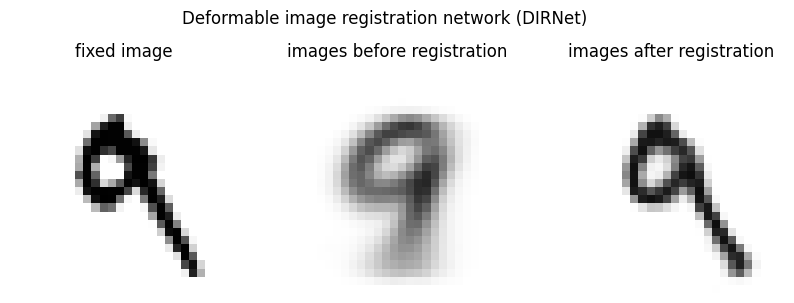

In [12]:
trainer.save_checkpoint(DEST_DIR / 'mnist_dlir_8_4.ckpt')
torch.save(model5.state_dict(), DEST_DIR / 'mnist_dlir_8_4.pt')  # model7
visualize(model5)

100%|██████████| 1009/1009 [00:04<00:00, 231.77it/s]


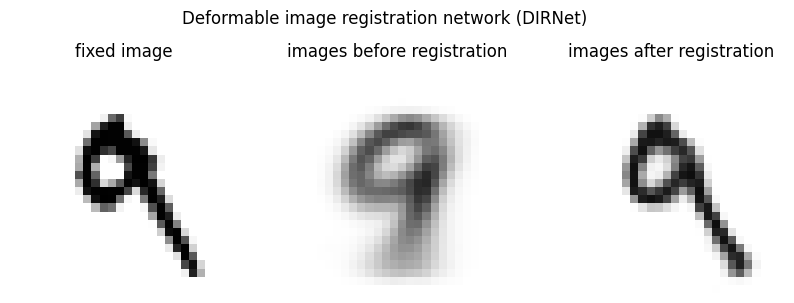

In [28]:
model6 = LitDLIRFramework()
model6.add_stage(network=DIRNet(grid_spacing=(8, 8), kernels=16, num_conv_layers=5, num_dense_layers=2),
                transformer=BsplineTransformer(ndim=2, upsampling_factors=(8, 8)))
model6.add_stage(network=DIRNet(grid_spacing=(4, 4), kernels=16, num_conv_layers=5, num_dense_layers=2),
                transformer=BsplineTransformer(ndim=2, upsampling_factors=(4, 4)))

# Load checkpoint
checkpoint = torch.load(DEST_DIR / 'mnist_dlir_8_4.ckpt')

corrected_state_dict = {f"dlir_framework.{k.replace('dlir_framework.', '')}": v for k, v in checkpoint['state_dict'].items()}

# Load the corrected_state_dict into model6
model6.load_state_dict(corrected_state_dict)

visualize(model6)

100%|██████████| 1009/1009 [00:04<00:00, 244.98it/s]


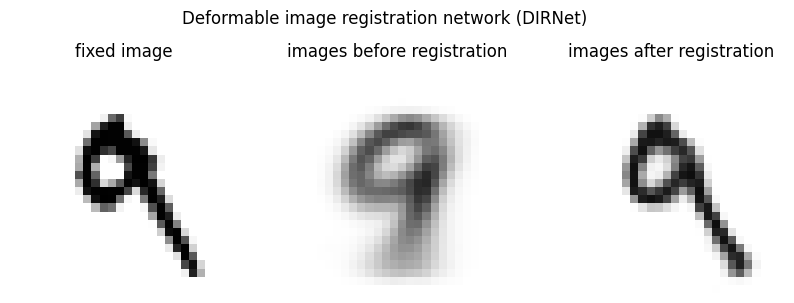

In [29]:
model7 = LitDLIRFramework()
model7.add_stage(network=DIRNet(grid_spacing=(8, 8), kernels=16, num_conv_layers=5, num_dense_layers=2),
                transformer=BsplineTransformer(ndim=2, upsampling_factors=(8, 8)))
model7.add_stage(network=DIRNet(grid_spacing=(4, 4), kernels=16, num_conv_layers=5, num_dense_layers=2),
                transformer=BsplineTransformer(ndim=2, upsampling_factors=(4, 4)))

checkpoint = torch.load(DEST_DIR / 'mnist_dlir_8_4.pt')

corrected_state_dict = {f"dlir_framework.{k.replace('dlir_framework.', '')}": v for k, v in checkpoint.items()}

model7.load_state_dict(corrected_state_dict)

visualize(model7)

100%|██████████| 1009/1009 [00:04<00:00, 229.23it/s]


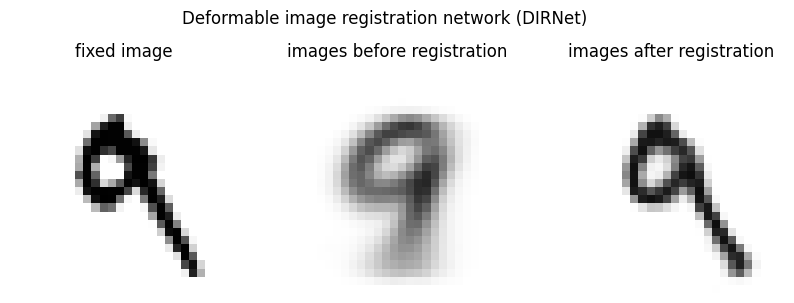

In [30]:
model8 = LitDLIRFramework()
model8.add_stage(network=DIRNet(grid_spacing=(8, 8), kernels=16, num_conv_layers=5, num_dense_layers=2),
                transformer=BsplineTransformer(ndim=2, upsampling_factors=(8, 8)))
model8.add_stage(network=DIRNet(grid_spacing=(4, 4), kernels=16, num_conv_layers=5, num_dense_layers=2),
                transformer=BsplineTransformer(ndim=2, upsampling_factors=(4, 4)))

checkpoint = torch.load("C:\\Users\\s4692034\\Documents\\GitHub\\TorchIR\\MNIST_output\\lightning_logs\\version_7\\checkpoints\\epoch=99-step=10000.ckpt")

corrected_state_dict = {f"dlir_framework.{k.replace('dlir_framework.', '')}": v for k, v in checkpoint['state_dict'].items()}
model8.load_state_dict(corrected_state_dict)
visualize(model8)